# Preprocessing and clustering 3k PBMCs

[paraphrase]
We gratefully acknowledge Seurat’s and Scanpy's authors for the tutorials.

The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics (here from this webpage). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [2]:
import scelephant as el
from scelephant import RamData

"""
configure the jupyter notebook environment
"""
el.bk.Wide( 100 ) # adjust the jupyter notebook cell width 

In [3]:
# delete the intermediate output folders
!rm -rf "data/"
!rm -rf "output/"

In [4]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data && tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz && gzip filtered_gene_bc_matrices/hg19/* && mv filtered_gene_bc_matrices/hg19/genes.tsv.gz filtered_gene_bc_matrices/hg19/features.tsv.gz
!mkdir output

--2023-09-12 20:18:58--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2023-09-12 20:18:59--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  5.95MB/s    in 1.2s    

2023-09-12 20:19:01 (5.95 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matric

In [5]:
# not use GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# import scelephant
import scelephant as el
from scelephant import RamData

"""
configure the jupyter notebook environment
"""
el.bk.Wide( 100 ) # adjust the jupyter notebook cell width 

import matplotlib as mpl
mpl.rcParams[ "figure.dpi" ] = 100
# set image resolution

# load memory profiler 
# %load_ext memory_profiler

**Convert MTX -> RamData**

In [6]:
# define working directory
path_folder_pipeline = os.getcwd( ) + '/' # retrieve current working directory

# create RamData from 10X-formateed MTX
el.create_ramdata_from_mtx( 
    path_folder_mtx_10x_input = f'data/filtered_gene_bc_matrices/hg19/', 
    path_folder_ramdata_output = f'output/pbmc3k.ram/',
)

**loading RamData**

In [7]:
ram = el.RamData( f'output/pbmc3k.ram/' )

2023-09-12 20:19:07,832 [SC-Elephant] <INFO> (layer) - 'raw' layer has been loaded


**view RamData**

In [8]:
ram

<RamData object (2700 barcodes X 32738 features, 2286884 records in the currently active layer 'raw') stored at /home/merit_an/git/scelephant/doc/jn/tutorials/output/pbmc3k.ram/
	with the following layers : {'raw'}
		current layer is 'raw'>

**preprocessing**

2023-09-12 20:19:11,090 [SC-Elephant] <INFO> (prepare_dimension_reduction_from_raw) - [SLOW MODE] converting dense to sparse formats ... 
raw/dense > raw/sparse_for_querying_features: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2286884.0/2286884 [00:01<00:00, 1540900.73it/s]
raw/dense > raw/sparse_for_querying_barcodes: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

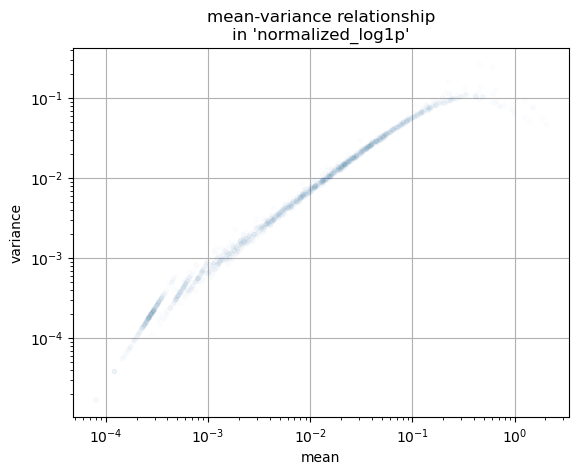

In [9]:
# slow analysis
ram.int_num_cpus = 8 # number of cores to use
# preprocess outputs
ram.prepare_dimension_reduction_from_raw( 
    name_layer_raw = 'raw', 
    name_layer_capped = 'normalized_log1p_capped',
    name_layer_scaled = None, 
    name_col_filter_filtered_barcode = 'filtered_barcodes', 
    min_counts = 500, 
    min_features = 200, 
    int_total_count_target = 10_000, 
    int_num_highly_variable_features = 2_000, 
    name_col_filter_highly_variable = 'filter_normalized_log1p_highly_variable_2000',
    max_value = 10, 
    dict_kw_hv = { 'float_min_mean' : 0.01, 'float_min_variance' : 0.01 }, 
    flag_use_fast_mode = False, # set this flag to True for fast exploratory analysis without generating intermediate layers
)

**prepare dimension reduction**

In [ ]:
# perform UMAP embedding
ram.perform_dimension_reduction_and_clustering(
    name_layer_pca = 'normalized_log1p_capped', 
    name_filter_barcodes = 'filtered_barcodes',
    name_filter_features = 'filter_normalized_log1p_highly_variable_2000',
    str_embedding_method = 'scanpy-umap'
)

In [ ]:
adata = ram[
    'normalized_log1p_capped',
    :,
    [ 'str', { 'X_umap_scanpy', 'X_pca_scanpy' }, 'leiden_scanpy' ],
    [ 'PTPRC', 'CD8A', 'CD4' ],
    [ 'str' ]
]

In [ ]:
ram.bc.columns

In [ ]:
int_num_barcodes_in_pumap_batch = 22000
int_num_barcodes_for_a_batch = 20000
float_prop_subsampling_pca = 0.3

**train PCA**

In [ ]:
ram.train_pca( 
    name_layer = 'normalized_log1p_scaled', 
    int_num_components = 30, 
    int_num_barcodes_in_ipca_batch = int_num_barcodes_for_a_batch, 
    name_col_filter = 'filter_pca', 
    float_prop_subsampling = float_prop_subsampling_pca, 
    name_col_filter_subsampled = 'filter_pca_subsampled', 
    flag_ipca_whiten = False, 
    name_model = 'ipca', 
    int_num_threads = 3, 
    flag_show_graph = True
)

In [ ]:
%memit

**apply PCA**

In [ ]:
ram.apply_pca( 
    name_model = 'ipca', 
    name_layer = 'normalized_log1p_scaled', 
    name_col = 'X_pca', 
    name_col_filter = 'filter_pca', 
    int_n_components_in_a_chunk = 20, 
    int_num_threads = 5
)

In [ ]:
%memit

**perform subsampling**

In [ ]:
ram

In [ ]:
ram.subsample( 
    int_num_entries_to_use = int_num_barcodes_for_a_batch, 
    int_num_entries_to_subsample = int_num_barcodes_in_pumap_batch, 
    int_num_iterations_for_subsampling = 2, 
    name_col_data = 'X_pca', 
    int_num_components_data = 20, 
    int_num_clus_expected = 20, 
    name_col_label = 'subsampling_label', 
    name_col_avg_dist = 'subsampling_avg_dist', 
    axis = 'barcodes', 
    name_col_filter = 'filter_pca', 
    name_col_filter_subsampled = "filter_subsampled", 
    resolution = 0.7, 
    directed = True, 
    use_weights = True, 
    dict_kw_leiden_partition = { 'n_iterations' : -1, 'seed' : 0 }, 
    n_neighbors = 20, 
    dict_kw_pynndescent = { 'low_memory' : True, 'n_jobs' : None, 'compressed' : False }, 
    int_num_threads = 10, 
    int_num_entries_in_a_batch = int_num_barcodes_for_a_batch
)

In [ ]:
%memit

**1st UMAP training**

In [ ]:
ram.bc.change_filter( 'filter_subsampled' )
ram.train_umap( 
    name_col_pca = 'X_pca', 
    int_num_components_pca = 20, 
    int_num_components_umap = 2, 
    name_col_filter = 'filter_subsampled', 
    name_pumap_model = 'pumap'
)

In [ ]:
%memit

**2nd UMAP training**

In [ ]:
ram

In [ ]:
# 2nd training
ram.bc.change_filter( 'filtered_barcodes' )
ram.bc.filter = ram.bc.subsample( min( 1, int_num_barcodes_in_pumap_batch / ram.bc.filter.count( ) ) )
ram.bc.save_filter( 'filter_subsampled_randomly' )
ram.train_umap( 
    name_col_pca = 'X_pca', 
    int_num_components_pca = 20, 
    int_num_components_umap = 2, 
    name_col_filter = 'filter_subsampled_randomly', 
    name_pumap_model = 'pumap'
)

In [ ]:
%memit

**Apply trained p-UMAP model**

In [ ]:
# apply umap
ram.apply_umap( name_col_pca = 'X_pca', name_col_umap = 'X_umap', int_num_barcodes_in_pumap_batch = int_num_barcodes_for_a_batch, name_col_filter = 'filtered_barcodes', name_pumap_model = 'pumap' )

In [ ]:
%memit

**Convert RamData -> Scanpy AnnData for further detailed analysis**

In [ ]:
# subsample features
ram.ft.filter = ram.ft.subsample( 0.01 )

In [ ]:
ram

In [ ]:
adata = ram[ 'raw', :, [ 'str', 'raw_sum', 'filter_subsampled', 'filter_subsampled_randomly', 'filter_subsampled', { 'X_umap', 'subsampling_label' } ], :, [ 'str', 'raw_normalized_log1p_mean' ] ]
adata.obs[ 'name_sample' ] = list( e.split( '|', 1 )[ 0 ] for e in adata.obs.index.values )
adata.obs[ 'leiden_scelephant' ] = adata.obsm[ 'subsampling_label' ][ :, 1 ]
adata.obs[ 'leiden_scelephant' ] = adata.obs[ 'leiden_scelephant' ].astype( str ).astype( object )

In [ ]:
%memit

In [ ]:
import scanpy as sc

In [ ]:
sc.pl.umap( adata, color = 'leiden_scelephant' )

In [ ]:
sc.pl.umap( adata, color = 'name_sample', palette = 'gist_rainbow' )

In [ ]:
for e in adata.var.index.values[ : 3 ] :
    sc.pl.umap( adata, color = e, cmap = 'Reds', vmax = 5 )

# inside 'prepare_dimension_reduction_from_raw'

In [ ]:
self = ram
name_layer_raw = 'raw'
name_layer_out = 'normalized_log1p_scaled'
min_counts = 500
min_features = 100
int_total_count_target = 10000
int_num_highly_variable_features = 2000
max_value = 10
dict_kw_hv = { 'float_min_mean' : 0.01, 'float_min_variance' : 0.01, 'name_col_filter' : 'filter_normalized_log1p_highly_variable' } 

**cell filtering**

In [ ]:
self.summarize( name_layer_raw, 'barcode', 'sum' )

In [ ]:
%memit

In [ ]:
# filter cells
self.bc.filter = ( self.bc.all( ) if self.bc.filter is None else self.bc.filter ) & BA.to_bitarray( self.bc.meta[ f'{name_layer_raw}_sum', : ] > min_counts ) & BA.to_bitarray( self.bc.meta[ f'{name_layer_raw}_num_nonzero_values', : ] > min_features )
self.bc.save_filter( 'filtered_barcodes' ) # save filter for later analysis


In [ ]:
ram

In [ ]:
%memit

**surveying feature variance**

In [ ]:
# retrieve total raw count data for normalization
self.bc.meta.load_as_dict( f'{name_layer_raw}_sum' )
dict_count = self.bc.meta.dict[ f'{name_layer_raw}_sum' ] # retrieve total counts for each barcode as a dictionary

# retrieve the total number of barcodes
int_total_num_barcodes = self.bc.meta.n_rows

def func( self, int_entry_of_axis_for_querying, arr_int_entries_of_axis_not_for_querying, arr_value ) : # normalize count data of a single feature containing (possibly) multiple barcodes
    """ # 2022-07-06 23:58:38 
    """
    # perform normalization in-place
    for i, e in enumerate( arr_int_entries_of_axis_not_for_querying.astype( int ) ) : # iterate through barcodes
        arr_value[ i ] = arr_value[ i ] / dict_count[ e ] # perform normalization using the total count data for each barcode
    arr_value *= int_total_count_target

    # perform log1p transformation 
    arr_value = np.log10( arr_value + 1 )

    # calculate deviation
    int_num_records = len( arr_value ) # retrieve the number of records of the current entry
    dict_summary = { 'normalized_log1p_sum' : np.sum( arr_value ) if int_num_records > 30 else sum( arr_value ) } # if an input array has more than 30 elements, use np.sum to calculate the sum
    dict_summary[ 'normalized_log1p_mean' ] = dict_summary[ 'normalized_log1p_sum' ] / int_total_num_barcodes # calculate the mean
    arr_dev = ( arr_value - dict_summary[ 'normalized_log1p_mean' ] ) ** 2 # calculate the deviation
    dict_summary[ 'normalized_log1p_deviation' ] = np.sum( arr_dev ) if int_num_records > 30 else sum( arr_dev )
    dict_summary[ 'normalized_log1p_variance' ] = dict_summary[ 'normalized_log1p_deviation' ] / ( int_total_num_barcodes - 1 ) if int_total_num_barcodes > 1 else np.nan
    return dict_summary    

# calculate the metric for identifying highly variable genes
self.summarize( name_layer_raw, 'feature', func )


In [ ]:
%memit

In [ ]:
# identify highly variable genes
self.identify_highly_variable_features( name_layer = f'{name_layer_raw}_normalized_log1p', int_num_highly_variable_features = int_num_highly_variable_features, flag_show_graph = True, ** dict_kw_hv )

In [ ]:
%memit

**write normalized, scaled, log-transformed count data**

In [ ]:
# retrieve variance
self.ft.meta.load_as_dict( f'{name_layer_raw}_normalized_log1p_variance' )
dict_var = self.ft.meta.dict[ f'{name_layer_raw}_normalized_log1p_variance' ] # retrieve total counts for each barcode as a dictionary

# write log-normalized, scaled data for the selected highly variable features
def func( self, int_entry_of_axis_for_querying, arr_int_entries_of_axis_not_for_querying, arr_value ) : 
    """ # 2022-07-06 23:58:38 
    """
    # perform normalization 
    arr_value *= int_total_count_target / dict_count[ int_entry_of_axis_for_querying ] # perform normalization using the total count data for each barcode

    # perform log1p transformation 
    arr_value = np.log10( arr_value + 1 )

    # perform scaling in-place
    for i, e in enumerate( arr_int_entries_of_axis_not_for_querying.astype( int ) ) : # iterate through features
        arr_value[ i ] = arr_value[ i ] / dict_var[ e ] ** 0.5
    arr_value[ arr_value > max_value ] = max_value # capping values above 'max_value'

    # return results
    return int_entry_of_axis_for_querying, arr_int_entries_of_axis_not_for_querying, arr_value
self.apply( name_layer_raw, name_layer_out, func, [ [ 'dense', 'sparse_for_querying_barcodes' ] ] )

In [ ]:
%memit